# Sentiment Classifier

## Libraries

In [167]:
# IO
import os
import csv
import pathlib
from pathlib import Path
import warnings
from tqdm.notebook import tqdm

# Utilities
import numpy as np 
import pandas as pd
import copy

# Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling and Training
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix
)

In [88]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/exterior/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/exterior/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/exterior/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Classes

### Models

In [89]:
class CorpoSpeakDecoder(tf.keras.Model):
    def __init__(
        self, 
        max_features, 
        input_length, 
        embedding_dim, 
        lstm_units,
        dropout_embedding, 
        dropout_lstm, 
        recurrent_dropout,
        dense_units, 
        dropout_dense,
        num_classes=3
        ):
        super().__init__()

        self.model = Sequential([
            Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=input_length),
            SpatialDropout1D(dropout_embedding),
            LSTM(lstm_units, dropout=dropout_lstm, recurrent_dropout=recurrent_dropout),
            Dropout(0.2),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_dense),
            Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        return self.model(inputs)

    def build_model(self):
        self.build(input_shape=(None, self.model.layers[0].input_length))
        return self.model


In [90]:
class RNN(tf.keras.Model):
    def __init__(
        self, 
        max_features, 
        input_length, 
        embedding_dim, 
        dense_units=64,
        num_classes=3
        ):
        super().__init__()

        self.model = Sequential([
            Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=input_length),
            SimpleRNN(dense_units, activation='tanh', return_sequences=False),                   
            Dense(num_classes, activation='sigmoid')
            ])

    def call(self, inputs):
        return self.model(inputs)

    def build_model(self):
        self.build(input_shape=(None, self.model.layers[0].input_length))
        return self.model



## Functions

### Preprocessing

The encoding of the text file is automatically detected here with some confidence. It could be extracted from terminal using
```
file -I file.txt
```

Terminal method (not os agnostic):

In [91]:
#!file -i ~/Documents/StudyResources/IML/Project/Part2/_data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt

Python method:

In [92]:
def extract_sentences_from_file(filepath):
    """Given an input txt file, extract sentences 
    and associated sentiments

    Args:
        filepath (string): path to string 

    Returns:
        list: list of sentences and sentiments
    """
    sentences = []
    # automatically detect endoding (best guess)
    with open(filepath, 'rb') as file:
        encoding = chardet.detect(file.read())['encoding']
    # read and split
    with open(filepath, 'r', encoding=encoding) as file:
        for line in file:
            line = line.strip()
            if '.@' in line:
                sentence, sentiment = line.rsplit('.@', 1)
                sentence = sentence.strip()
                sentiment = sentiment.strip().lower()
                sentence = fix_common_mojibake(sentence)
                sentences.append((sentence, sentiment))
    return sentences

Create csv files

In [93]:
def txt_to_csv(txt_path, output_csv):
    """Takes a file path as input and generates a .csv file
    which contains sentences and sentiments as columns, extracted
    from the .txt file corresponding to the path

    Args:
        txt_path (string): path to the .txt file
        output_csv (string): path to desired output .csv file
    """
    # Skip processing if CSV already exists
    if os.path.exists(output_csv):
        print(f"{output_csv} already exists. Skipping processing.")
        return

    sentences = extract_sentences_from_file(txt_path)

    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Sentence', 'Sentiment'])  # Header
        writer.writerows(sentences)
    print(f"Processed files and wrote output to {output_csv}")


This function is needed as the text files seem to be corrupted, for example one sentence is:
```
Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004
```
The characters `+ñ` are a result of choosing the wrong encoding; in fact, here the detected encoding is latin-1, and those characters correspond to `ä` in utf-8. The function below is used to fix these common mistakes

In [94]:
def fix_common_mojibake(text):
    """Function to manually handle encoding errors

    Args:
        text (string): input sentence

    Returns:
        string: output corrected sentence
    """
    replacements = {
        '+ñ': 'ä',
        '+í': 'é',
        '+ô': 'ö',
        '+ü': 'ü'
        }
    for wrong, right in replacements.items():
        text = text.replace(wrong, right)
    return text

This function summarizes the common preprocessing pipeline for natural language models.

In [95]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

Create numerical sequences from text, to be fed to the models

In [96]:
def create_sequences(
    text, 
    tokenizer, 
    max_length=200
    ):
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, maxlen=max_length)
    return X

Function that creates csv files (if not created already) and returns the dataframe extracted from them

In [97]:
def create_df():
    """Import data and creates csv's and pandas dataframes

    Returns:
        pandas dataframes for training and testing
    """
    print("Please select which dataset to use. Data is categorized based on the percentage of agreement in the sentiment estimator.")
    print("Options:")
    print("(1) 50")
    print("(2) 66")
    print("(3) 75")
    print("(4) 100")
    percentage = input()
    if percentage=='50':
        txt_path = RAW_DATA_FOLDER + 'Sentences_50Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_50.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='66':
        txt_path = RAW_DATA_FOLDER + 'Sentences_66Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_66.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='75':
        txt_path = RAW_DATA_FOLDER + 'Sentences_75Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_75.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='100':
        txt_path = RAW_DATA_FOLDER + 'Sentences_AllAgree.txt'
        csv_path = DATASET_FOLDER + 'sentences_100.csv'
        txt_to_csv(txt_path, csv_path)
    else:
        print("The percentage provided is not admitted, skipping.")
        return

    df = pd.read_csv(csv_path)

    le = LabelEncoder()
    le.fit(df['Sentiment'])
    df['Sentiment_encoded'] = le.transform(df['Sentiment'])

    return df, le

### Training

In [133]:
def train_model(
    X_train,X_val,y_train,y_val,
    model,
    device,
    best_params = None,
    epochs=30
    ):
            
    if best_params:
        lr = best_params['learning_rate']
        batch_size = best_params['batch_size']
    else:
        lr = 0.001
        batch_size = 32

    with tf.device(device):
        
        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=3, 
            min_delta=0.02,
            restore_best_weights=True
            )
    
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )

    return model, history

#### Pretraining evaluation

In [118]:
def pretraining_evaluation( 
    df,
    model,
    cv,
    device,
    best_params = None,
    epochs=10,   
    max_features=5000, 
    max_length=200
    ):
        
    if best_params:
        lr = best_params['learning_rate']
        batch_size = best_params['batch_size']
    else:
        lr = 0.001
        batch_size = 32

    val_scores = []

    texts = df['Sentence'].tolist()
    labels = df['Sentiment_encoded'].values  # assuming labels are integers

    for fold_idx, (train_idx, val_idx) in enumerate(tqdm(cv.split(texts, labels), total=cv.get_n_splits(), desc="CV Folds")):
        with tf.device(device):
            tf.keras.backend.clear_session()

            text_train_raw = [texts[i] for i in train_idx]
            text_val_raw = [texts[i] for i in val_idx]

            # Apply preprocessing per fold
            text_train = [preprocess_text(t) for t in text_train_raw]
            text_val = [preprocess_text(t) for t in text_val_raw]

            # Fit tokenizer on processed training text
            tokenizer = Tokenizer(num_words=max_features)
            tokenizer.fit_on_texts(text_train)

            X_train_fold = create_sequences(text_train, tokenizer, max_length=max_length)
            X_val_fold = create_sequences(text_val, tokenizer, max_length=max_length)

            y_train_fold = labels[train_idx]
            y_val_fold = labels[val_idx] 

            # New model for each fold
            model_copy = model
            

            early_stop = EarlyStopping(
                monitor='val_loss', 
                patience=3, 
                min_delta=0.03,
                restore_best_weights=True)

            model_copy.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=10,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )

            val_accuracy = model_copy.evaluate(X_val_fold, y_val_fold, verbose=1)[1]
            val_scores.append(val_accuracy)
    
    avg_score = np.mean(val_scores)
    dev_score = np.std(val_scores)
    print(f"Validation Score: {avg_score:.4f} ± {dev_score:.4f}")

    return val_scores


### Hyperparameter tuning

In [98]:
def objective_corpo(
    trial, 
    df,
    cv,  
    device, 
    max_features=5000, 
    max_length=200
    ):
    val_scores = []

    # Hyperparameters
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256])
    lstm_units = trial.suggest_int("lstm_units", 64, 256, step=32)
    dropout_embedding = trial.suggest_float("dropout_embedding", 0.2, 0.5)
    dropout_lstm = trial.suggest_float("dropout_lstm", 0.1, 0.5)
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.1, 0.5)
    dense_units = trial.suggest_int("dense_units", 64, 256, step=32)
    dropout_dense = trial.suggest_float("dropout_dense", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])


    texts = df['Sentence'].tolist()
    labels = df['Sentiment_encoded'].values  # assuming labels are integers

    for fold_idx, (train_idx, val_idx) in enumerate(tqdm(cv.split(texts, labels), total=cv.get_n_splits(), desc="CV Folds")):
        with tf.device(device):

            tf.keras.backend.clear_session()

            text_train_raw = [texts[i] for i in train_idx]
            text_val_raw = [texts[i] for i in val_idx]

            # Apply preprocessing per fold
            text_train = [preprocess_text(t) for t in text_train_raw]
            text_val = [preprocess_text(t) for t in text_val_raw]

            # Fit tokenizer on processed training text
            tokenizer = Tokenizer(num_words=max_features)
            tokenizer.fit_on_texts(text_train)

            X_train_fold = create_sequences(text_train, tokenizer, max_length=max_length)
            X_val_fold = create_sequences(text_val, tokenizer, max_length=max_length)

            y_train_fold = labels[train_idx]
            y_val_fold = labels[val_idx] 

            model_wrapper = CorpoSpeakDecoder(
                max_features=max_features,
                input_length=max_length,
                embedding_dim=embedding_dim,
                lstm_units=lstm_units,
                dropout_embedding=dropout_embedding,
                dropout_lstm=dropout_lstm,
                recurrent_dropout=recurrent_dropout,
                dense_units=dense_units,
                dropout_dense=dropout_dense
            )

            model = model_wrapper.build_model()
            model.compile(
                loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )

            early_stop = EarlyStopping(
                monitor='val_loss', 
                patience=3, 
                min_delta=0.03,
                restore_best_weights=True
                )

            model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=10,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
                )

            val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=1)[1]
            val_scores.append(val_accuracy)

    return np.mean(val_scores)


In [110]:
def objective_rnn(
    trial, 
    df,
    cv,   
    device,
    max_features=5000, 
    max_length=200
    ):
    val_scores = []

    # Hyperparameters
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256])
    dense_units = trial.suggest_int("dense_units", 16, 112, step=16)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    texts = df['Sentence'].tolist()
    labels = df['Sentiment_encoded'].values  # assuming labels are integers

    for fold_idx, (train_idx, val_idx) in enumerate(tqdm(cv.split(texts, labels), total=cv.get_n_splits(), desc="CV Folds")):
        with tf.device(device):

            tf.keras.backend.clear_session()

            text_train_raw = [texts[i] for i in train_idx]
            text_val_raw = [texts[i] for i in val_idx]

            # Apply preprocessing per fold
            text_train = [preprocess_text(t) for t in text_train_raw]
            text_val = [preprocess_text(t) for t in text_val_raw]

            # Fit tokenizer on processed training text
            tokenizer = Tokenizer(num_words=max_features)
            tokenizer.fit_on_texts(text_train)

            X_train_fold = create_sequences(text_train, tokenizer, max_length=max_length)
            X_val_fold = create_sequences(text_val, tokenizer, max_length=max_length)

            y_train_fold = labels[train_idx]
            y_val_fold = labels[val_idx] 

            model_wrapper = RNN(
                max_features=max_features,
                input_length=max_length,
                embedding_dim=embedding_dim,
                dense_units=dense_units
            )

            model = model_wrapper.build_model()
            model.compile(
                loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )

            early_stop = EarlyStopping(
                monitor='val_loss', 
                patience=3, 
                min_delta=0.03,
                restore_best_weights=True)

            model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=10,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )

            val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=1)[1]
            val_scores.append(val_accuracy)

    return np.mean(val_scores)


### Testing

In [165]:
def test_model(
    df_test,
    model,
    device,
    le
    ):

    texts_test = df_test['Sentence'].tolist()
    y_test = df_test['Sentiment_encoded'].values

    text_test = [preprocess_text(t) for t in texts_test]

    X_test = create_sequences(text_test, tokenizer, max_length=200)

    with tf.device(device):
        # Generate predictions
        y_pred_proba = model.predict(X_test)

        y_pred_proba_normalized = y_pred_proba / np.sum(y_pred_proba, axis=1, keepdims=True)
        
        # Convert probabilities to class predictions
        y_pred = np.argmax(y_pred_proba_normalized, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # AUC (One-vs-Rest approach)
    auc_score = roc_auc_score(
        y_test,
        y_pred_proba_normalized,
        multi_class='ovr',
        average='macro'
    )
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print(f"AUC (OvR Macro): {auc_score:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot ROC curves
    n_classes = y_pred_proba_normalized.shape[1]
    if le is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    else:
        class_names = le.inverse_transform(df_test['Sentiment_encoded'].unique()).tolist()
    
    
    # Binarize the labels for OvR ROC
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_normalized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (OvR)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

## Main

### Data preparation understanding

OS-agnostic working folder and data folder definition

In [100]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
RAW_DATA_FOLDER = os.path.join(str(DATASET_FOLDER), "FinancialPhraseBank-v1.0","")

In [101]:
data_csv_path = DATASET_FOLDER+'data.csv'

Import data into pandas dataframe

In [102]:
df, le = create_df()

Please select which dataset to use. Data is categorized based on the percentage of agreement in the sentiment estimator.
Options:
(1) 50
(2) 66
(3) 75
(4) 100
/Users/exterior/Documents/IML/Project/Part2/_data/sentences_100.csv already exists. Skipping processing.


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sentence           2208 non-null   object
 1   Sentiment          2208 non-null   object
 2   Sentiment_encoded  2208 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 51.9+ KB


Split data into testing and training

In [104]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Sentiment_encoded"],
    random_state=42
    )

Select gpu if available

In [169]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

In [170]:
device

'/CPU:0'

### Hyperparameter search

In [105]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [106]:
rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

Hyperparameter search

In [111]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_rnn(trial, df_train, rskf), n_trials=10
    )

[I 2025-06-21 15:15:01,138] A new study created in memory with name: no-name-08cc8b97-0155-441c-abc0-92b7d774d4ea


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
10/10 [==============================] - 1s 98ms/step - loss: 1.2480 - accuracy: 0.3297 - val_loss: 1.3696 - val_accuracy: 0.1392
Epoch 2/10
10/10 [==============================] - 1s 93ms/step - loss: 1.1520 - accuracy: 0.4613 - val_loss: 1.3312 - val_accuracy: 0.2581
Epoch 3/10
10/10 [==============================] - 1s 93ms/step - loss: 1.0035 - accuracy: 0.5888 - val_loss: 0.9436 - val_accuracy: 0.6587
Epoch 4/10
10/10 [==============================] - 1s 96ms/step - loss: 0.9329 - accuracy: 0.5132 - val_loss: 0.8810 - val_accuracy: 0.7029
Epoch 5/10
10/10 [==============================] - 1s 92ms/step - loss: 0.8515 - accuracy: 0.6126 - val_loss: 0.8077 - val_accuracy: 0.6418
Epoch 6/10
10/10 [==============================] - 1s 102ms/step - loss: 0.7201 - accuracy: 0.6644 - val_loss: 0.8277 - val_accuracy: 0.7063
Epoch 7/10
10/10 [==============================] - 1s 92ms/step - loss: 0.7734 - accuracy: 0.6865 - val_loss: 0.8116 - val_accuracy: 0.6723
Epoch 8/10
1

[I 2025-06-21 15:16:11,597] Trial 0 finished with value: 0.6993206275833977 and parameters: {'embedding_dim': 128, 'dense_units': 96, 'learning_rate': 0.004210146744135194, 'batch_size': 128}. Best is trial 0 with value: 0.6993206275833977.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
19/19 [==============================] - 2s 76ms/step - loss: 1.0110 - accuracy: 0.5429 - val_loss: 0.9451 - val_accuracy: 0.6146
Epoch 2/10
19/19 [==============================] - 1s 72ms/step - loss: 0.8814 - accuracy: 0.6151 - val_loss: 0.8966 - val_accuracy: 0.6197
Epoch 3/10
19/19 [==============================] - 1s 74ms/step - loss: 0.8194 - accuracy: 0.6415 - val_loss: 0.8715 - val_accuracy: 0.6384
Epoch 4/10
19/19 [==============================] - 1s 70ms/step - loss: 0.7509 - accuracy: 0.6873 - val_loss: 0.8478 - val_accuracy: 0.6553
Epoch 5/10
19/19 [==============================] - 1s 74ms/step - loss: 0.6791 - accuracy: 0.7477 - val_loss: 0.8341 - val_accuracy: 0.6774
Epoch 6/10
19/19 [==============================] - 1s 73ms/step - loss: 0.6153 - accuracy: 0.7986 - val_loss: 0.7955 - val_accuracy: 0.6706
Epoch 7/10
19/19 [==============================] - 1s 76ms/step - loss: 0.5375 - accuracy: 0.8224 - val_loss: 0.7742 - val_accuracy: 0.6944
Epoch 8/10
19

[I 2025-06-21 15:18:35,925] Trial 1 finished with value: 0.7315815753406949 and parameters: {'embedding_dim': 256, 'dense_units': 80, 'learning_rate': 0.00017470331563534602, 'batch_size': 64}. Best is trial 1 with value: 0.7315815753406949.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
19/19 [==============================] - 1s 46ms/step - loss: 0.9469 - accuracy: 0.5939 - val_loss: 0.8061 - val_accuracy: 0.6808
Epoch 2/10
19/19 [==============================] - 1s 41ms/step - loss: 0.9071 - accuracy: 0.5455 - val_loss: 0.8251 - val_accuracy: 0.6825
Epoch 3/10
19/19 [==============================] - 1s 42ms/step - loss: 0.6957 - accuracy: 0.7383 - val_loss: 0.8106 - val_accuracy: 0.6876
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.8061 - accuracy: 0.6808
Epoch 1/10
19/19 [==============================] - 1s 46ms/step - loss: 0.9181 - accuracy: 0.5998 - val_loss: 0.8009 - val_accuracy: 0.6655
Epoch 2/10
19/19 [==============================] - 1s 41ms/step - loss: 0.4272 - accuracy: 0.8105 - val_loss: 1.0015 - val_accuracy: 0.6163
Epoch 3/10
19/19 [==============================] - 1s 41ms/step - loss: 0.2046 - accuracy: 0.9159 - val_loss: 1.0860 - val_accuracy: 0.6655
Epoch 4/10
19/19 [==============================] - 0s 6

[I 2025-06-21 15:19:33,764] Trial 2 finished with value: 0.6970524059401618 and parameters: {'embedding_dim': 128, 'dense_units': 80, 'learning_rate': 0.007951501761228313, 'batch_size': 64}. Best is trial 1 with value: 0.7315815753406949.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
37/37 [==============================] - 1s 21ms/step - loss: 1.0245 - accuracy: 0.5404 - val_loss: 0.9327 - val_accuracy: 0.6197
Epoch 2/10
37/37 [==============================] - 1s 18ms/step - loss: 0.8827 - accuracy: 0.6474 - val_loss: 0.8782 - val_accuracy: 0.6299
Epoch 3/10
37/37 [==============================] - 1s 18ms/step - loss: 0.8090 - accuracy: 0.6916 - val_loss: 0.8346 - val_accuracy: 0.6842
Epoch 4/10
37/37 [==============================] - 1s 18ms/step - loss: 0.7442 - accuracy: 0.7443 - val_loss: 0.8006 - val_accuracy: 0.6859
Epoch 5/10
37/37 [==============================] - 1s 18ms/step - loss: 0.6868 - accuracy: 0.7757 - val_loss: 0.7729 - val_accuracy: 0.6978
Epoch 6/10
37/37 [==============================] - 1s 18ms/step - loss: 0.6386 - accuracy: 0.8046 - val_loss: 0.7577 - val_accuracy: 0.7012
Epoch 7/10
37/37 [==============================] - 1s 19ms/step - loss: 0.5958 - accuracy: 0.8241 - val_loss: 0.7363 - val_accuracy: 0.7046
Epoch 8/10
37

[I 2025-06-21 15:20:55,238] Trial 3 finished with value: 0.7278115815586514 and parameters: {'embedding_dim': 128, 'dense_units': 16, 'learning_rate': 0.00012125952753154915, 'batch_size': 32}. Best is trial 1 with value: 0.7315815753406949.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
19/19 [==============================] - 2s 76ms/step - loss: 0.9231 - accuracy: 0.5820 - val_loss: 0.8155 - val_accuracy: 0.6587
Epoch 2/10
19/19 [==============================] - 1s 66ms/step - loss: 0.6815 - accuracy: 0.7358 - val_loss: 0.7211 - val_accuracy: 0.6978
Epoch 3/10
19/19 [==============================] - 1s 65ms/step - loss: 0.5013 - accuracy: 0.8275 - val_loss: 0.6627 - val_accuracy: 0.7368
Epoch 4/10
19/19 [==============================] - 1s 73ms/step - loss: 0.3450 - accuracy: 0.9218 - val_loss: 0.6541 - val_accuracy: 0.7351
Epoch 5/10
19/19 [==============================] - 1s 73ms/step - loss: 0.2181 - accuracy: 0.9499 - val_loss: 0.6246 - val_accuracy: 0.7402
Epoch 6/10
19/19 [==============================] - 1s 71ms/step - loss: 0.1523 - accuracy: 0.9813 - val_loss: 0.6455 - val_accuracy: 0.7317
Epoch 7/10
19/19 [==============================] - 1s 68ms/step - loss: 0.0994 - accuracy: 0.9924 - val_loss: 0.6641 - val_accuracy: 0.7368
Epoch 8/10
19

[I 2025-06-21 15:23:02,952] Trial 4 finished with value: 0.7527414295408461 and parameters: {'embedding_dim': 256, 'dense_units': 80, 'learning_rate': 0.0003942203813257788, 'batch_size': 64}. Best is trial 4 with value: 0.7527414295408461.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
10/10 [==============================] - 1s 95ms/step - loss: 0.9935 - accuracy: 0.4894 - val_loss: 0.8987 - val_accuracy: 0.6248
Epoch 2/10
10/10 [==============================] - 1s 81ms/step - loss: 0.7786 - accuracy: 0.7077 - val_loss: 0.8073 - val_accuracy: 0.6469
Epoch 3/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6382 - accuracy: 0.7613 - val_loss: 0.7542 - val_accuracy: 0.7046
Epoch 4/10
10/10 [==============================] - 1s 86ms/step - loss: 0.5130 - accuracy: 0.8581 - val_loss: 0.7026 - val_accuracy: 0.7199
Epoch 5/10
10/10 [==============================] - 1s 85ms/step - loss: 0.3952 - accuracy: 0.9065 - val_loss: 0.6878 - val_accuracy: 0.7284
Epoch 6/10
10/10 [==============================] - 1s 87ms/step - loss: 0.2914 - accuracy: 0.9482 - val_loss: 0.6669 - val_accuracy: 0.7284
Epoch 7/10
10/10 [==============================] - 1s 85ms/step - loss: 0.2154 - accuracy: 0.9711 - val_loss: 0.6531 - val_accuracy: 0.7284
Epoch 8/10
10

[I 2025-06-21 15:24:42,278] Trial 5 finished with value: 0.7472521596484714 and parameters: {'embedding_dim': 256, 'dense_units': 48, 'learning_rate': 0.0005196948184507379, 'batch_size': 128}. Best is trial 4 with value: 0.7527414295408461.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
37/37 [==============================] - 1s 23ms/step - loss: 0.9962 - accuracy: 0.5837 - val_loss: 0.9209 - val_accuracy: 0.6146
Epoch 2/10
37/37 [==============================] - 1s 21ms/step - loss: 0.9051 - accuracy: 0.6151 - val_loss: 0.8955 - val_accuracy: 0.6146
Epoch 3/10
37/37 [==============================] - 1s 21ms/step - loss: 0.8743 - accuracy: 0.6151 - val_loss: 0.8665 - val_accuracy: 0.6146
Epoch 4/10
37/37 [==============================] - 1s 21ms/step - loss: 0.8291 - accuracy: 0.6406 - val_loss: 0.8333 - val_accuracy: 0.6333
Epoch 5/10
37/37 [==============================] - 1s 21ms/step - loss: 0.7746 - accuracy: 0.6848 - val_loss: 0.7925 - val_accuracy: 0.6723
Epoch 6/10
37/37 [==============================] - 1s 21ms/step - loss: 0.7093 - accuracy: 0.7307 - val_loss: 0.7522 - val_accuracy: 0.6825
Epoch 7/10
37/37 [==============================] - 1s 21ms/step - loss: 0.6327 - accuracy: 0.7545 - val_loss: 0.7107 - val_accuracy: 0.7301
Epoch 8/10
37

[I 2025-06-21 15:26:15,144] Trial 6 finished with value: 0.728573222955068 and parameters: {'embedding_dim': 64, 'dense_units': 64, 'learning_rate': 0.0001139086204915276, 'batch_size': 32}. Best is trial 4 with value: 0.7527414295408461.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
37/37 [==============================] - 1s 21ms/step - loss: 1.0258 - accuracy: 0.5472 - val_loss: 0.9596 - val_accuracy: 0.6333
Epoch 2/10
37/37 [==============================] - 1s 20ms/step - loss: 0.8633 - accuracy: 0.6797 - val_loss: 0.9468 - val_accuracy: 0.6435
Epoch 3/10
37/37 [==============================] - 1s 20ms/step - loss: 0.7607 - accuracy: 0.7434 - val_loss: 0.8899 - val_accuracy: 0.6689
Epoch 4/10
37/37 [==============================] - 1s 20ms/step - loss: 0.6526 - accuracy: 0.8029 - val_loss: 0.8443 - val_accuracy: 0.6689
Epoch 5/10
37/37 [==============================] - 1s 20ms/step - loss: 0.5546 - accuracy: 0.8471 - val_loss: 0.8426 - val_accuracy: 0.6842
Epoch 6/10
37/37 [==============================] - 1s 20ms/step - loss: 0.4643 - accuracy: 0.9048 - val_loss: 0.8537 - val_accuracy: 0.6791
Epoch 7/10
37/37 [==============================] - 1s 19ms/step - loss: 0.3971 - accuracy: 0.9320 - val_loss: 0.8182 - val_accuracy: 0.6859
Epoch 8/10
37

[I 2025-06-21 15:27:39,494] Trial 7 finished with value: 0.7233101460668776 and parameters: {'embedding_dim': 128, 'dense_units': 16, 'learning_rate': 0.0003087898880845861, 'batch_size': 32}. Best is trial 4 with value: 0.7527414295408461.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
10/10 [==============================] - 1s 91ms/step - loss: 0.9854 - accuracy: 0.5293 - val_loss: 0.9240 - val_accuracy: 0.6146
Epoch 2/10
10/10 [==============================] - 1s 81ms/step - loss: 0.7258 - accuracy: 0.7417 - val_loss: 0.8054 - val_accuracy: 0.7267
Epoch 3/10
10/10 [==============================] - 1s 82ms/step - loss: 0.5746 - accuracy: 0.8088 - val_loss: 0.7672 - val_accuracy: 0.7080
Epoch 4/10
10/10 [==============================] - 1s 86ms/step - loss: 0.2763 - accuracy: 0.9490 - val_loss: 0.8092 - val_accuracy: 0.6638
Epoch 5/10
10/10 [==============================] - 1s 88ms/step - loss: 0.1381 - accuracy: 0.9703 - val_loss: 0.8475 - val_accuracy: 0.6638
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.7672 - accuracy: 0.7080
Epoch 1/10
10/10 [==============================] - 1s 88ms/step - loss: 0.9464 - accuracy: 0.5633 - val_loss: 0.8836 - val_accuracy: 0.6146
Epoch 2/10
10/10 [==============================] - 1s 7

[I 2025-06-21 15:28:44,141] Trial 8 finished with value: 0.6896693176693387 and parameters: {'embedding_dim': 64, 'dense_units': 96, 'learning_rate': 0.003570493009600542, 'batch_size': 128}. Best is trial 4 with value: 0.7527414295408461.


CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
10/10 [==============================] - 1s 69ms/step - loss: 0.8718 - accuracy: 0.6287 - val_loss: 0.7393 - val_accuracy: 0.6842
Epoch 2/10
10/10 [==============================] - 1s 60ms/step - loss: 0.4909 - accuracy: 0.8037 - val_loss: 0.6243 - val_accuracy: 0.7402
Epoch 3/10
10/10 [==============================] - 1s 62ms/step - loss: 0.2801 - accuracy: 0.9031 - val_loss: 0.6298 - val_accuracy: 0.7470
Epoch 4/10
10/10 [==============================] - 1s 63ms/step - loss: 0.1521 - accuracy: 0.9550 - val_loss: 0.6335 - val_accuracy: 0.7589
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.6243 - accuracy: 0.7402
Epoch 1/10
10/10 [==============================] - 1s 74ms/step - loss: 1.0296 - accuracy: 0.4894 - val_loss: 1.0449 - val_accuracy: 0.4261
Epoch 2/10
10/10 [==============================] - 1s 61ms/step - loss: 0.6014 - accuracy: 0.7969 - val_loss: 0.7115 - val_accuracy: 0.7284
Epoch 3/10
10/10 [==============================] - 1s 6

[I 2025-06-21 15:29:41,718] Trial 9 finished with value: 0.7400984499189589 and parameters: {'embedding_dim': 128, 'dense_units': 64, 'learning_rate': 0.002122434941697282, 'batch_size': 128}. Best is trial 4 with value: 0.7527414295408461.


In [114]:
study.best_params

{'embedding_dim': 256,
 'dense_units': 80,
 'learning_rate': 0.0003942203813257788,
 'batch_size': 64}

### Build models

In [ ]:
with tf.device(device):
    rnn_wrapper = RNN(
        max_features=5000,
        input_length=200,
        embedding_dim=study.best_params['embedding_dim'],
        dense_units=study.best_params['dense_units'],
        )

    rnn = rnn_wrapper.build_model()
    rnn.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=study.best_params['learning_rate']),
        metrics=['accuracy']
        )

### Pretraining evaluation

In [119]:
pretraining_val_accs  = pretraining_evaluation(
    df_train,
    rnn,
    rskf,
    best_params=study.best_params
    )

CV Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10
19/19 [==============================] - 2s 72ms/step - loss: 0.8694 - accuracy: 0.6287 - val_loss: 0.8249 - val_accuracy: 0.6248
Epoch 2/10
19/19 [==============================] - 1s 69ms/step - loss: 0.6508 - accuracy: 0.7434 - val_loss: 0.6920 - val_accuracy: 0.7165
Epoch 3/10
19/19 [==============================] - 1s 69ms/step - loss: 0.4756 - accuracy: 0.8386 - val_loss: 0.6322 - val_accuracy: 0.7317
Epoch 4/10
19/19 [==============================] - 1s 69ms/step - loss: 0.3337 - accuracy: 0.9057 - val_loss: 0.6152 - val_accuracy: 0.7538
Epoch 5/10
19/19 [==============================] - 1s 71ms/step - loss: 0.2236 - accuracy: 0.9550 - val_loss: 0.6103 - val_accuracy: 0.7555
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 0.6322 - accuracy: 0.7317
Epoch 1/10
19/19 [==============================] - 1s 72ms/step - loss: 0.7119 - accuracy: 0.7205 - val_loss: 0.6742 - val_accuracy: 0.7284
Epoch 2/10
19/19 [==============================] - 1s 6

### Training

In [135]:
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train["Sentiment_encoded"],
    random_state=42
    )

texts_train = df_train['Sentence'].tolist()
y_train = df_train['Sentiment_encoded'].values  # assuming labels are integers

texts_val = df_val['Sentence'].tolist()
y_val = df_val['Sentiment_encoded'].values  # assuming labels are integers

text_train = [preprocess_text(t) for t in texts_train]
text_val = [preprocess_text(t) for t in texts_val]

# Fit tokenizer on processed training text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text_train)

X_train = create_sequences(text_train, tokenizer, max_length=200)
X_val = create_sequences(text_val, tokenizer, max_length=200)

In [136]:
rnn, history = train_model(
    X_train,X_val,y_train,y_val,
    rnn,
    best_params = study.best_params
    )

Epoch 1/30


23/23 [==============================] - 2s 71ms/step - loss: 0.9787 - accuracy: 0.5305 - val_loss: 0.8505 - val_accuracy: 0.6186
Epoch 2/30
23/23 [==============================] - 1s 65ms/step - loss: 0.7339 - accuracy: 0.7181 - val_loss: 0.7593 - val_accuracy: 0.6921
Epoch 3/30
23/23 [==============================] - 1s 63ms/step - loss: 0.5389 - accuracy: 0.8343 - val_loss: 0.6802 - val_accuracy: 0.7175
Epoch 4/30
23/23 [==============================] - 2s 71ms/step - loss: 0.3556 - accuracy: 0.9200 - val_loss: 0.6444 - val_accuracy: 0.7458
Epoch 5/30
23/23 [==============================] - 2s 66ms/step - loss: 0.2107 - accuracy: 0.9681 - val_loss: 0.6477 - val_accuracy: 0.7316
Epoch 6/30
23/23 [==============================] - 2s 69ms/step - loss: 0.1371 - accuracy: 0.9788 - val_loss: 0.6317 - val_accuracy: 0.7514
Epoch 7/30
23/23 [==============================] - 2s 70ms/step - loss: 0.0900 - accuracy: 0.9908 - val_loss: 0.6289 - val_accuracy: 0.7373


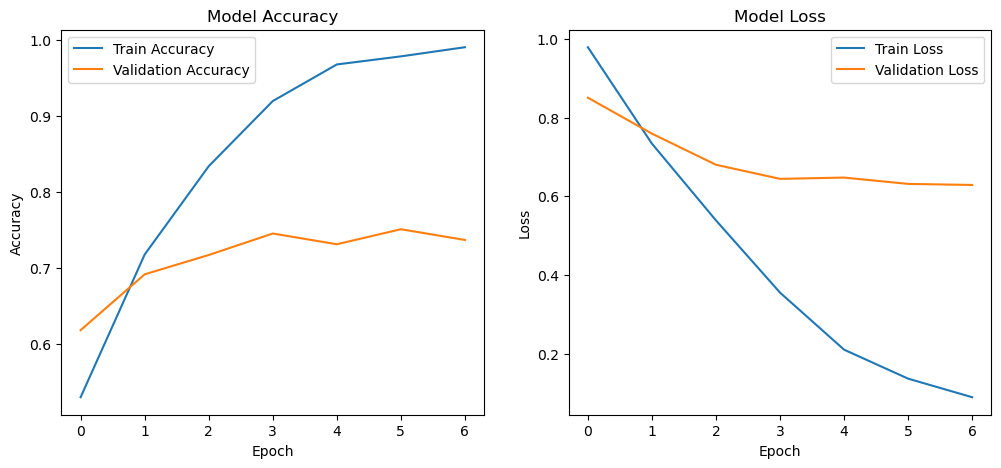

In [137]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Testing

14/14 [==============================] - 0s 8ms/step
Accuracy: 0.7330
Precision (Macro): 0.6230
Recall (Macro): 0.5346
F1-Score (Macro): 0.5518
AUC (OvR Macro): 0.8345
Confusion Matrix:
[[ 13  20  26]
 [  0 266   6]
 [ 13  53  45]]


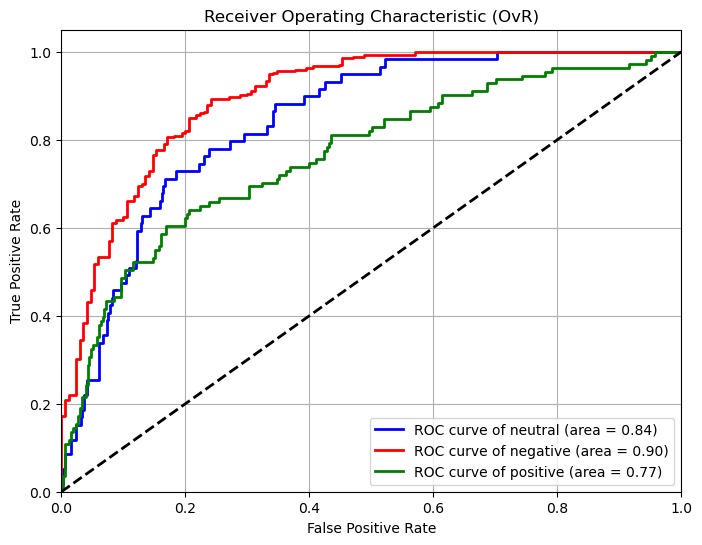

In [168]:
scores = test_model(df_test, rnn, le)